In [400]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.ensemble import MajorityVotingClassifier
from skmultilearn.cluster import FixedLabelSpaceClusterer
from skmultilearn.ensemble import RakelO
from skmultilearn.model_selection import IterativeStratification
from xgboost import XGBClassifier
# from sklearn.dummy import DummyClassifier
from mlxtend.evaluate.time_series import GroupTimeSeriesSplit
from mlxtend.evaluate.time_series import plot_splits
from mlxtend.evaluate.time_series import print_cv_info
from mlxtend.evaluate.time_series import print_split_info
import optuna
from functools import partial
from collected_functions import *

Load combined MA and DDS training data

In [332]:
df = pd.read_parquet('combined_training_set.parquet')
# df = df.sort_values(by='year', ascending=True)
# df = df[df['year']>=2016]
print(df.shape)
df.head()

(6566, 21)


,incidentId,state,incidentTypeMA,region,maType,maPriority,supportFunction,agencyId,maId,declarationType,...,statementOfWork,femaDeclarationString,incidentType,incidentBeginDate,fipsStateCode,designatedIncidentTypes,declarationTitle,year,month,day
45,2018072401,CA,Fire,9,FOS,High,13.0,DHS-FPS,4382DRCAFPS01,DR,...,"As directed by an in coordination with FEMA, F...",DR-4382-CA,Fire,2018-07-23 00:00:00+00:00,6.0,Fire,WILDFIRES AND HIGH WINDS,2018.0,7.0,23.0
66,2018072401,CA,Fire,9,FOS,High,10.0,EPA,4382DRCAEPA01,DR,...,"As directed by and in coordination with FEMA, ...",DR-4382-CA,Fire,2018-07-23 00:00:00+00:00,6.0,Fire,WILDFIRES AND HIGH WINDS,2018.0,7.0,23.0
136,2018072401,CA,Fire,9,FOS,Lifesaving,1.0,DOT,4382DRCADOT01,DR,...,"As directed by and in coordination with FEMA, ...",DR-4382-CA,Fire,2018-07-23 00:00:00+00:00,6.0,Fire,WILDFIRES AND HIGH WINDS,2018.0,7.0,23.0
152,2023121901,ME,Severe Storm,1,FOS,Normal,7.0,GSA,4754DRMEGSA03,DR,...,"As directed by and in coordination with FEMA, ...",DR-4754-ME,Severe Storm,2023-12-17 00:00:00+00:00,23.0,"Severe Storm,Flood",SEVERE STORM AND FLOODING,2023.0,12.0,17.0
153,2023121901,ME,Severe Storm,1,FOS,High,7.0,GSA,4754DRMEGSA02,DR,...,"As directed by and in coordination with FEMA, ...",DR-4754-ME,Severe Storm,2023-12-17 00:00:00+00:00,23.0,"Severe Storm,Flood",SEVERE STORM AND FLOODING,2023.0,12.0,17.0


Compared to the original multilabel_classification_condensed notebook which grouped by state/incidentType/region, the approach in this notebook will group by incidentId, state, incidentType, and region. 

In [333]:
feature_columns = [
    'incidentId',
    'state',
    'designatedIncidentTypes',
    'declarationType',
    'region',
    'year',
    'incidentType',
]
kept_feature_columns = [
    'incidentId',
    'state',
    'declarationType',
    'region',
    'incidentType',
]
target_column = 'supportFunction'

X_train, y_train = create_set(df, feature_columns, target_column)

print(X_train.shape, len(y_train))
print(y_train[:5])
X_train.head(5)

(485, 7) 485
0    [1.0, 3.0, 4.0, 7.0, 8.0, 10.0, 11.0, 12.0, 15.0]
1                                                [4.0]
2                                                [7.0]
3                                                [2.0]
4                                                [7.0]
Name: supportFunction, dtype: object


,incidentId,state,designatedIncidentTypes,declarationType,region,year,incidentType
0,2012102505,CT,Hurricane,DR,1,2012.0,Hurricane
1,2012102505,DC,Hurricane,EM,3,2012.0,Hurricane
2,2012102505,DE,Hurricane,DR,3,2012.0,Hurricane
3,2012102505,DE,Hurricane,EM,3,2012.0,Hurricane
4,2012102505,MD,Hurricane,DR,3,2012.0,Hurricane


In [334]:
X_train['designatedIncidentTypes'] = X_train['designatedIncidentTypes'].str.split(',')


In [335]:
feature_columns_transform = [
    # 'incidentId',
    'state',
    # 'designatedIncidentTypes',
    'declarationType',
    'region',
    'incidentType',
]
X_train_transformed, y_train_transformed, preprocessor_X, preprocessor_y = transform_x_y_train(
    X_train,
    y_train,
    feature_columns_transform,
    ['designatedIncidentTypes'],
    target_column
)

In [336]:
groups_by_year = X_train_transformed['year'].values
X_train_transformed.drop(columns=['incidentId', 'year'], inplace=True)
print(X_train_transformed.shape)
X_train_transformed.head()

(485, 107)


,state_AK,state_AL,state_AR,state_AS,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,...,designatedIncidentTypes_Severe Ice Storm,designatedIncidentTypes_Severe Storm,designatedIncidentTypes_Snowstorm,designatedIncidentTypes_Straight-Line Winds,designatedIncidentTypes_Terrorist,designatedIncidentTypes_Tornado,designatedIncidentTypes_Tropical Storm,designatedIncidentTypes_Typhoon,designatedIncidentTypes_Volcanic Eruption,designatedIncidentTypes_Winter Storm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [337]:
print(y_train_transformed.shape)
y_train_transformed.head()

(485, 16)


,ESF_0,ESF_1,ESF_2,ESF_3,ESF_4,ESF_5,ESF_6,ESF_7,ESF_8,ESF_9,ESF_10,ESF_11,ESF_12,ESF_13,ESF_14,ESF_15
0,0,1,0,1,1,0,0,1,1,0,1,1,1,0,0,1
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


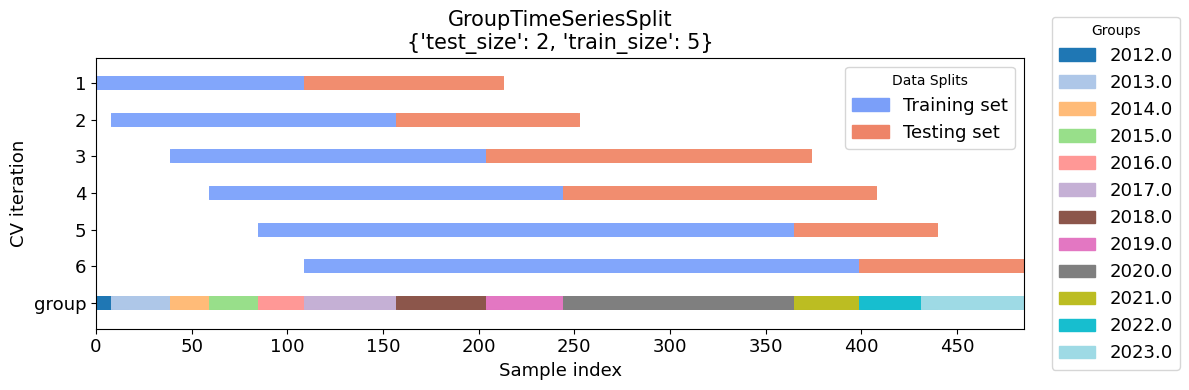

Train indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113]
Test indices: [114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208]
Train length: 114
Test length: 95
Train groups: [2012. 2012. 2012. 2012. 2012. 2012. 2012. 2012. 2012. 2012. 2012. 2012.

In [342]:
cv_args = {"test_size": 2, "train_size": 5}
plot_splits(X_train_transformed, y_train_transformed, groups_by_year, **cv_args)
print_split_info(X_train_transformed, y_train_transformed, groups_by_year, **cv_args)

In [343]:
cv = GroupTimeSeriesSplit(**cv_args)

In [345]:
clf = BinaryRelevance(
    classifier = XGBClassifier(
        max_depth=10,
        random_state=0,
        n_estimators=100,
        base_score=0.5
        ),
    require_dense = [True, True]
)

scores = cross_val_score(clf,
                         X_train_transformed,
                         y_train_transformed,
                         groups=groups_by_year,
                         scoring="f1_macro",
                         cv=cv)

print(scores)

print_cv_info(cv,
              X_train_transformed,
              y_train_transformed,
              groups_by_year,
              clf,
              scores)

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

F-s

[0.30187654 0.36898608 0.29250249 0.33037339 0.45889123 0.39433399]
Split number: 1
Train true target: [[0 1 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]]
Train predicted target: <Compressed Sparse Column sparse matrix of dtype 'int64'
	with 251 stored elements and shape (114, 16)>
  Coords	Values
  (0, 1)	1
  (5, 1)	1
  (10, 1)	1
  (11, 1)	1
  (36, 1)	1
  (108, 1)	1
  (10, 2)	1
  (11, 2)	1
  (0, 3)	1
  (5, 3)	1
  (7, 3)	1
  (10, 3)	1
  (11, 3)	1
  (13, 3)	1
  (16, 3)	1
  (19, 3)	1
  (30, 3)	1
  (32, 3)	1
  (34, 3)	1
  (36, 3)	1
  (37, 3)	1
  (41, 3)	1
  (43, 3)	1
  (44, 3)	1
  (45, 3)	1
  :	:
  (36, 11)	1
  (81, 11)	1
  (82, 11)	1
  (87, 11)	1
  (91, 11)	1
  (99, 11)	1
  (10, 12)	1
  (11, 12)	1
  (49, 12)	1
  (59, 12)	1
  (79, 12)	1
  (10, 13)	1
  (11, 13)	1
  (13, 13)	1
  (16, 13)	1
  (19, 13)	1
  (36, 13)	1
  (70, 13)	1
  (83, 13)	1
  (88, 13)	1
  (97, 13)	1
  (103, 13)	1
  (105, 13)	1
  (107, 13)	1
  (109, 13)	1
Te

Testing Binary Relevance model for ability to predict support functions from provided features.

In [ ]:
base_SVC = SVC(
        gamma='auto',
        decision_function_shape='ovo',
        class_weight='balanced',
        )

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_transformed)

base_XGB = XGBClassifier(
        max_depth=12,
        random_state=0,
        n_estimators=100,
        base_score=0.5,
        # scale_pos_weight=5.5,
        sample_weights = sample_weights,
        )

base_GNB = GaussianNB()

In [347]:
br_classifier_svc = BinaryRelevance(
    classifier = base_SVC,
    require_dense = [True, True]
)
br_classifier_svc.fit(X_train_transformed, y_train_transformed)

predictions_brsvc = br_classifier_svc.predict(X_train_transformed)
predictions_brsvc_dense = predictions_brsvc.toarray()
display_results(y_train_transformed, predictions_brsvc_dense)

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but SVC was fitted without feature names

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but SVC was fitted without feature names

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but SVC was fitted without feature names

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but SVC was fitted without feature names

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but SVC was fitted without feature names

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



In [348]:
br_classifier_XGB = BinaryRelevance(
    classifier = base_XGB,
    require_dense = [True, True]
)
br_classifier_XGB.fit(X_train_transformed, y_train_transformed)

predictions_brxgb = br_classifier_XGB.predict(X_train_transformed)
predictions_brxgb_dense = predictions_brxgb.toarray()
display_results(y_train_transformed, predictions_brxgb_dense)

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning:

[17:07:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292871873/work/src/learner.cc:738: 
Parameters: { "sample_weights" } are not used.


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning:

[17:07:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292871873/work/src/learner.cc:738: 
Parameters: { "sample_weights" } are not used.


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning:

[17:07:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292871873/work/src/learner.cc:738: 
Parameters: { "sample_weights" } are not used.




True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



In [349]:
br_classifier_gnb = BinaryRelevance(
    classifier = base_GNB,
    require_dense = [True, True]
)
br_classifier_gnb.fit(X_train_transformed, y_train_transformed)

predictions_brgnbbr_classifier_gnb = br_classifier_gnb.predict(X_train_transformed)
predictions_brgnbbr_classifier_gnb_dense = predictions_brgnbbr_classifier_gnb.toarray()
display_results(y_train_transformed, predictions_brgnbbr_classifier_gnb_dense)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[1 1 0 0 1 0 0 1 0 0 1 1 1 0 0 1]
 [0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 0]
 [0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0]
 [0 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but GaussianNB was fitted without feature names

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but GaussianNB was fitted without feature names

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but GaussianNB was fitted without feature names

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but GaussianNB was fitted without feature names

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but GaussianNB was fitted without feature names

/Users/joschw/opt/anaconda3/envs/milestone2/l

Binary Relevance is a decent baseline. The next model up is Classifier Chain, which should perform better if set up correctly.

In [350]:
cc_classifier_svc = ClassifierChain(
    classifier=base_SVC, 
    # chains=10, 
    require_dense=[True, True],
    order = list(range(0,16)),
)

cc_classifier_svc.fit(X_train_transformed, y_train_transformed)
predictions_ccs_dense = cc_classifier_svc.predict(X_train_transformed)
predictions_ccs_dense_dense = predictions_ccs_dense.toarray()
display_results(y_train_transformed, predictions_ccs_dense_dense)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



In [399]:
cc_classifier_xgb = ClassifierChain(
    classifier=base_XGB, 
    # chains=10, 
    require_dense=[True, True],
    order = 'random',
)

cc_classifier_xgb.fit(X_train_transformed, y_train_transformed)
predictions_ccs_dense = cc_classifier_xgb.predict(X_train_transformed)
predictions_ccs_dense_dense = predictions_ccs_dense.toarray()
display_results(y_train_transformed, predictions_ccs_dense_dense)

IndexError: Index dimension must be 1 or 2

In [352]:
cc_classifier_gnb = ClassifierChain(
    classifier=base_GNB, 
    # chains=10, 
    require_dense=[True, True],
    order = list(range(0,16)),
)

cc_classifier_gnb.fit(X_train_transformed, y_train_transformed)
predictions_ccs_dense = cc_classifier_gnb.predict(X_train_transformed)
predictions_ccs_dense_dense = predictions_ccs_dense.toarray()
display_results(y_train_transformed, predictions_ccs_dense_dense)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0. 

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



Check if outcomes improve by rearranging order based on frequency. Use best classifier from previous round.

In [353]:
label_orders = y_train.explode().value_counts().index.astype(int).tolist()

cc_classifier = ClassifierChain(
    classifier=base_XGB, 
    require_dense=[True, True],
    order = label_orders,
)

cc_classifier.fit(X_train_transformed, y_train_transformed)

predictions_cc = cc_classifier.predict(X_train_transformed)
predictions_cc_dense = predictions_cc.toarray()
display_results(y_train_transformed, predictions_cc_dense)


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning:

[17:07:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292871873/work/src/learner.cc:738: 
Parameters: { "sample_weights" } are not used.


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning:

[17:07:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292871873/work/src/learner.cc:738: 
Parameters: { "sample_weights" } are not used.




True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



Results for the default order using XGBoost show it is the best performer so far.

Moving on to a new model type. RAkELo: random overlapping label space division with Label Powerset is up next.

In [354]:
classifier_rake_svc = RakelO(
   base_classifier=base_SVC,
    base_classifier_require_dense=[True, True],
    labelset_size=3,
    model_count=32
)

classifier_rake_svc.fit(X_train_transformed, y_train_transformed)
predictions_rakesvc = classifier_rake_svc.predict(X_train_transformed)
predictions_rakesvc_dense = predictions_rakesvc.toarray()
display_results(y_train_transformed, predictions_rakesvc_dense)

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but SVC was fitted without feature names

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but SVC was fitted without feature names

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but SVC was fitted without feature names

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but SVC was fitted without feature names

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but SVC was fitted without feature names

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1]
 [0 0 1 1 0 1 0 1 1 1 0 0 1 1 0 1]
 [0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1]
 [0 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1]
 [0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



In [355]:
classifier_rake_xgb = RakelO(
   base_classifier=base_XGB,
    base_classifier_require_dense=[True, True],
    labelset_size=3,
    model_count=32
)

classifier_rake_xgb.fit(X_train_transformed, y_train_transformed)
predictions_rakexgb = classifier_rake_xgb.predict(X_train_transformed)
predictions_rakexgb_dense = predictions_rakexgb.toarray()
display_results(y_train_transformed, predictions_rakexgb_dense)

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning:

[17:07:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292871873/work/src/learner.cc:738: 
Parameters: { "sample_weights" } are not used.


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning:

[17:07:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292871873/work/src/learner.cc:738: 
Parameters: { "sample_weights" } are not used.


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning:

[17:07:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292871873/work/src/learner.cc:738: 
Parameters: { "sample_weights" } are not used.


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning:

[17:07:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_174829287

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



In [356]:
classifier_rake3 = RakelO(
   base_classifier=base_XGB,
    base_classifier_require_dense=[True, True],
    labelset_size=3,
    model_count=36
)

classifier_rake3.fit(X_train_transformed, y_train_transformed)
predictions_rake3 = classifier_rake3.predict(X_train_transformed)
predictions_rake3_dense = predictions_rake3.toarray()
display_results(y_train_transformed, predictions_rake3_dense)

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning:

[17:08:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292871873/work/src/learner.cc:738: 
Parameters: { "sample_weights" } are not used.


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning:

[17:08:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292871873/work/src/learner.cc:738: 
Parameters: { "sample_weights" } are not used.


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning:

[17:08:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292871873/work/src/learner.cc:738: 
Parameters: { "sample_weights" } are not used.


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning:

[17:08:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_174829287

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



Results are much better, though we just measured results from the training set. We can take a quick deep dive into a correct prediction and incorrect prediction.

In [357]:
print(predictions_rake3_dense[4])
print(X_train.iloc[4], y_train_transformed.iloc[4])

[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
incidentId                  2012102505
state                               MD
designatedIncidentTypes    [Hurricane]
declarationType                     DR
region                               3
year                            2012.0
incidentType                 Hurricane
Name: 4, dtype: object ESF_0     0
ESF_1     0
ESF_2     0
ESF_3     0
ESF_4     0
ESF_5     0
ESF_6     0
ESF_7     1
ESF_8     0
ESF_9     0
ESF_10    0
ESF_11    0
ESF_12    0
ESF_13    0
ESF_14    0
ESF_15    0
Name: 4, dtype: int64


In [358]:
print(predictions_rake3_dense[0])
print(X_train.iloc[0], y_train_transformed.iloc[0])

[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
incidentId                  2012102505
state                               CT
designatedIncidentTypes    [Hurricane]
declarationType                     DR
region                               1
year                            2012.0
incidentType                 Hurricane
Name: 0, dtype: object ESF_0     0
ESF_1     1
ESF_2     0
ESF_3     1
ESF_4     1
ESF_5     0
ESF_6     0
ESF_7     1
ESF_8     1
ESF_9     0
ESF_10    1
ESF_11    1
ESF_12    1
ESF_13    0
ESF_14    0
ESF_15    1
Name: 0, dtype: int64


Interesting. Our results should have been the same but our prediction for a New York hurricane differs from a hurricane in New Jersey.

Our best classifier is RAkELo using XGBClassifier. Now we can perform hyperparameter tuning using Optuna and temporal cross validation. We will use Hamming Loss as our scoring metric.

In [ ]:
def objective(trial, X, y, groups, cv_args):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 150, step=25),
        'max_depth': trial.suggest_int('max_depth', 7, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        # 'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        # 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'base_score': 0.5, 
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }

    # RakelD parameters
    rakel_params = {
        # m: size of the random label subset (k)
        'labelset_size': trial.suggest_int('labelset_size', 2, 5), 
        # k: number of random labelsets
        'model_count': trial.suggest_int('model_count', 16, 40), 
    }
    
    # base_XGB = XGBClassifier(**xgb_params)
    
    # clf = RakelO(
    #     base_classifier=base_XGB,
    #     **rakel_params,
    #     base_classifier_require_dense=[True, True],
    # )

    scores = []    
    cv = IterativeStratification(
        n_splits=3,
        order=1
    )

    for train_index, val_index in cv.split(X, y, groups=groups):
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        sample_weights = compute_sample_weight(class_weight='balanced', y=y_tr)
        
        base_XGB = XGBClassifier(**xgb_params, sample_weights=sample_weights)
    
        # The RakelO multilabel classifier (the main estimator)
        clf = RakelO(
            base_classifier=base_XGB,
            **rakel_params,
            base_classifier_require_dense=[True, True],
        )
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        
        # Evaluate using Macro F1 (preferred for multilabel imbalance)
        # hl = hamming_loss(y_val, y_pred)
        hl = f1_score(y_val, y_pred, average='macro', zero_division=1)
        scores.append(hl)

    return np.mean(scores)


objective_gts = partial(objective,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        groups=groups_by_year,
                        cv_args=cv_args,
                        )

# 3. Create and Run the Optuna Study
# study = optuna.create_study(direction="minimize") # Minimize the Hamming Loss score
study = optuna.create_study(direction="maximize") # MAximize the F1 score

study.optimize(objective_gts, n_trials=20, show_progress_bar=True)

# --- Final Results ---
print("Optuna Hyperparameter Tuning Complete")
print(f"Best Hamming Score (Validation): {study.best_value:.4f}")
print("Best Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-12 17:08:35,819] A new study created in memory with name: no-name-95fb6634-0570-40bd-a2ad-96174446814f
Best trial: 0. Best value: 0.409671:   5%|▌         | 1/20 [00:30<09:35, 30.29s/it]

[I 2025-11-12 17:09:06,160] Trial 0 finished with value: 0.4096713436470682 and parameters: {'n_estimators': 125, 'max_depth': 13, 'learning_rate': 0.0053339982569185216, 'labelset_size': 3, 'model_count': 28}. Best is trial 0 with value: 0.4096713436470682.


Best trial: 1. Best value: 0.418925:  10%|█         | 2/20 [00:46<06:35, 21.98s/it]

[I 2025-11-12 17:09:22,320] Trial 1 finished with value: 0.4189245622681043 and parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.06916291061209394, 'labelset_size': 4, 'model_count': 25}. Best is trial 1 with value: 0.4189245622681043.


Best trial: 1. Best value: 0.418925:  15%|█▌        | 3/20 [01:07<06:09, 21.73s/it]

[I 2025-11-12 17:09:43,747] Trial 2 finished with value: 0.3890343209500588 and parameters: {'n_estimators': 125, 'max_depth': 12, 'learning_rate': 0.004659410482278851, 'labelset_size': 3, 'model_count': 21}. Best is trial 1 with value: 0.4189245622681043.


Best trial: 3. Best value: 0.443924:  20%|██        | 4/20 [01:25<05:21, 20.11s/it]

[I 2025-11-12 17:10:01,376] Trial 3 finished with value: 0.44392428879781437 and parameters: {'n_estimators': 125, 'max_depth': 9, 'learning_rate': 0.06562082629876, 'labelset_size': 2, 'model_count': 30}. Best is trial 3 with value: 0.44392428879781437.


Best trial: 3. Best value: 0.443924:  25%|██▌       | 5/20 [01:58<06:13, 24.88s/it]

[I 2025-11-12 17:10:34,716] Trial 4 finished with value: 0.36616923097067006 and parameters: {'n_estimators': 150, 'max_depth': 14, 'learning_rate': 0.002995886540004108, 'labelset_size': 4, 'model_count': 19}. Best is trial 3 with value: 0.44392428879781437.


Best trial: 3. Best value: 0.443924:  30%|███       | 6/20 [02:28<06:08, 26.33s/it]

[I 2025-11-12 17:11:03,876] Trial 5 finished with value: 0.38590851397046694 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.012974046406517229, 'labelset_size': 3, 'model_count': 30}. Best is trial 3 with value: 0.44392428879781437.


Best trial: 3. Best value: 0.443924:  35%|███▌      | 7/20 [02:56<05:52, 27.13s/it]

[I 2025-11-12 17:11:32,638] Trial 6 finished with value: 0.39614961679084243 and parameters: {'n_estimators': 50, 'max_depth': 14, 'learning_rate': 0.029844696938838403, 'labelset_size': 5, 'model_count': 38}. Best is trial 3 with value: 0.44392428879781437.


Best trial: 3. Best value: 0.443924:  40%|████      | 8/20 [03:23<05:23, 26.98s/it]

[I 2025-11-12 17:11:59,315] Trial 7 finished with value: 0.39852811719669495 and parameters: {'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.01076938251287974, 'labelset_size': 4, 'model_count': 17}. Best is trial 3 with value: 0.44392428879781437.


Best trial: 3. Best value: 0.443924:  45%|████▌     | 9/20 [03:40<04:21, 23.80s/it]

[I 2025-11-12 17:12:16,106] Trial 8 finished with value: 0.3782965790906932 and parameters: {'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.0012961188968279626, 'labelset_size': 3, 'model_count': 40}. Best is trial 3 with value: 0.44392428879781437.


Best trial: 3. Best value: 0.443924:  50%|█████     | 10/20 [03:58<03:41, 22.12s/it]

[I 2025-11-12 17:12:34,481] Trial 9 finished with value: 0.3978893116682534 and parameters: {'n_estimators': 75, 'max_depth': 7, 'learning_rate': 0.024219940278208937, 'labelset_size': 4, 'model_count': 23}. Best is trial 3 with value: 0.44392428879781437.


Best trial: 3. Best value: 0.443924:  55%|█████▌    | 11/20 [04:24<03:29, 23.28s/it]

[I 2025-11-12 17:13:00,370] Trial 10 finished with value: 0.4280144140107803 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.09409108309913389, 'labelset_size': 2, 'model_count': 33}. Best is trial 3 with value: 0.44392428879781437.


Best trial: 3. Best value: 0.443924:  60%|██████    | 12/20 [04:43<02:56, 22.01s/it]

[I 2025-11-12 17:13:19,465] Trial 11 finished with value: 0.4333879034846612 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.09806050282722781, 'labelset_size': 2, 'model_count': 34}. Best is trial 3 with value: 0.44392428879781437.


Best trial: 3. Best value: 0.443924:  65%|██████▌   | 13/20 [05:01<02:25, 20.73s/it]

[I 2025-11-12 17:13:37,255] Trial 12 finished with value: 0.41910317112647394 and parameters: {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.04471432108512944, 'labelset_size': 2, 'model_count': 34}. Best is trial 3 with value: 0.44392428879781437.


Best trial: 3. Best value: 0.443924:  70%|███████   | 14/20 [05:23<02:06, 21.14s/it]

[I 2025-11-12 17:13:59,345] Trial 13 finished with value: 0.42289765369364835 and parameters: {'n_estimators': 125, 'max_depth': 9, 'learning_rate': 0.09304376351880762, 'labelset_size': 2, 'model_count': 35}. Best is trial 3 with value: 0.44392428879781437.


Best trial: 3. Best value: 0.443924:  75%|███████▌  | 15/20 [05:36<01:33, 18.70s/it]

[I 2025-11-12 17:14:12,404] Trial 14 finished with value: 0.43242195385402676 and parameters: {'n_estimators': 75, 'max_depth': 11, 'learning_rate': 0.04074306653729549, 'labelset_size': 2, 'model_count': 29}. Best is trial 3 with value: 0.44392428879781437.


Best trial: 3. Best value: 0.443924:  80%|████████  | 16/20 [05:51<01:10, 17.66s/it]

[I 2025-11-12 17:14:27,645] Trial 15 finished with value: 0.4045064919899564 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.019148340062942196, 'labelset_size': 2, 'model_count': 32}. Best is trial 3 with value: 0.44392428879781437.


Best trial: 16. Best value: 0.457752:  85%|████████▌ | 17/20 [06:41<01:22, 27.45s/it]

[I 2025-11-12 17:15:17,845] Trial 16 finished with value: 0.45775239239433074 and parameters: {'n_estimators': 125, 'max_depth': 10, 'learning_rate': 0.05406052234865862, 'labelset_size': 5, 'model_count': 26}. Best is trial 16 with value: 0.45775239239433074.


Best trial: 17. Best value: 0.460044:  90%|█████████ | 18/20 [07:28<01:06, 33.26s/it]

[I 2025-11-12 17:16:04,628] Trial 17 finished with value: 0.46004385266092496 and parameters: {'n_estimators': 125, 'max_depth': 10, 'learning_rate': 0.04927658440055939, 'labelset_size': 5, 'model_count': 26}. Best is trial 17 with value: 0.46004385266092496.


Best trial: 17. Best value: 0.460044:  95%|█████████▌| 19/20 [08:18<00:38, 38.25s/it]

[I 2025-11-12 17:16:54,519] Trial 18 finished with value: 0.44704177214939395 and parameters: {'n_estimators': 125, 'max_depth': 12, 'learning_rate': 0.018477934172931868, 'labelset_size': 5, 'model_count': 26}. Best is trial 17 with value: 0.46004385266092496.


Best trial: 17. Best value: 0.460044: 100%|██████████| 20/20 [08:50<00:00, 26.55s/it]

[I 2025-11-12 17:17:26,839] Trial 19 finished with value: 0.4417962263739667 and parameters: {'n_estimators': 75, 'max_depth': 10, 'learning_rate': 0.04182712184848406, 'labelset_size': 5, 'model_count': 23}. Best is trial 17 with value: 0.46004385266092496.
Optuna Hyperparameter Tuning Complete
Best Hamming Score (Validation): 0.4600
Best Parameters:
  n_estimators: 125
  max_depth: 10
  learning_rate: 0.04927658440055939
  labelset_size: 5
  model_count: 26


In [360]:
def objective2(trial, X, y, groups, cv_args):

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200, step=25),
        'max_depth': trial.suggest_int('max_depth', 7, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.95),
        'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 3, 10, log=True),
        'base_score': 0.5, 
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }

    
    base_XGB = XGBClassifier(**xgb_params)
    
    # The RakelO multilabel classifier (the main estimator)
    clf = BinaryRelevance(
        classifier = base_XGB,
        require_dense = [True, True]
    )

    scores = []    
    cv = GroupTimeSeriesSplit(**cv_args)

    for train_index, val_index in cv.split(X, y, groups=groups):
        X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        
        # Evaluate using Macro F1 (preferred for multilabel imbalance)
        # hl = hamming_loss(y_val, y_pred)
        hl = f1_score(y_val, y_pred, average='macro', zero_division=1)

        scores.append(hl)

    return np.mean(scores)


objective_gts = partial(objective2,
                        X=X_train_transformed,
                        y=y_train_transformed,
                        groups=groups_by_year,
                        cv_args=cv_args,
                        )

# 3. Create and Run the Optuna Study
# study2 = optuna.create_study(direction="minimize") # Minimize the Hamming Loss score
study2 = optuna.create_study(direction="maximize") # Maximize the F1 score

study2.optimize(objective_gts, n_trials=20, show_progress_bar=True)

# --- Final Results ---
print("Optuna Hyperparameter Tuning Complete")
print(f"Best Hamming Score (Validation): {study2.best_value:.4f}")
print("Best Parameters:")
for key, value in study2.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-12 17:17:27,100] A new study created in memory with name: no-name-24cfbcda-ea56-4bfe-9cdf-eef63fb53cb5
  0%|          | 0/20 [00:00<?, ?it/s]

Best trial: 0. Best value: 0.497007:   5%|▌         | 1/20 [00:02<00:52,  2.79s/it]

[I 2025-11-12 17:17:29,920] Trial 0 finished with value: 0.4970071050407788 and parameters: {'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.020235284855370832, 'subsample': 0.7220196211947746, 'colsample_bytree': 0.600221138301792, 'scale_pos_weight': 3.7808014341189766}. Best is trial 0 with value: 0.4970071050407788.


Best trial: 0. Best value: 0.497007:  10%|█         | 2/20 [00:08<01:23,  4.63s/it]

[I 2025-11-12 17:17:35,832] Trial 1 finished with value: 0.4850060281483124 and parameters: {'n_estimators': 125, 'max_depth': 10, 'learning_rate': 0.005987476603144716, 'subsample': 0.9323957167915402, 'colsample_bytree': 0.6016102040275232, 'scale_pos_weight': 4.378919194161601}. Best is trial 0 with value: 0.4970071050407788.


Best trial: 0. Best value: 0.497007:  15%|█▌        | 3/20 [00:15<01:34,  5.57s/it]

[I 2025-11-12 17:17:42,517] Trial 2 finished with value: 0.48617108363023237 and parameters: {'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.008749311658711298, 'subsample': 0.86107397276293, 'colsample_bytree': 0.9106976975841601, 'scale_pos_weight': 5.638078260303198}. Best is trial 0 with value: 0.4970071050407788.


Best trial: 0. Best value: 0.497007:  20%|██        | 4/20 [00:20<01:27,  5.48s/it]

[I 2025-11-12 17:17:47,868] Trial 3 finished with value: 0.4860341487729653 and parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.040670924709769095, 'subsample': 0.7390045707290631, 'colsample_bytree': 0.6149900972079226, 'scale_pos_weight': 4.397414626636572}. Best is trial 0 with value: 0.4970071050407788.


Best trial: 4. Best value: 0.501832:  25%|██▌       | 5/20 [00:23<01:06,  4.43s/it]

[I 2025-11-12 17:17:50,445] Trial 4 finished with value: 0.501832285535515 and parameters: {'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.004384316731707282, 'subsample': 0.9358281576013874, 'colsample_bytree': 0.6383471057421308, 'scale_pos_weight': 5.04407362966143}. Best is trial 4 with value: 0.501832285535515.


Best trial: 4. Best value: 0.501832:  30%|███       | 6/20 [00:26<00:54,  3.91s/it]

[I 2025-11-12 17:17:53,324] Trial 5 finished with value: 0.49379778281446063 and parameters: {'n_estimators': 50, 'max_depth': 12, 'learning_rate': 0.042077169852854215, 'subsample': 0.9070306902721001, 'colsample_bytree': 0.6041265028717324, 'scale_pos_weight': 8.14922233319102}. Best is trial 4 with value: 0.501832285535515.


Best trial: 6. Best value: 0.504456:  35%|███▌      | 7/20 [00:32<01:01,  4.73s/it]

[I 2025-11-12 17:17:59,739] Trial 6 finished with value: 0.5044559156107654 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.0029191549202651863, 'subsample': 0.8600164240023708, 'colsample_bytree': 0.8804901182915994, 'scale_pos_weight': 7.964007791069559}. Best is trial 6 with value: 0.5044559156107654.


Best trial: 7. Best value: 0.505202:  40%|████      | 8/20 [00:36<00:54,  4.50s/it]

[I 2025-11-12 17:18:03,763] Trial 7 finished with value: 0.5052019616081713 and parameters: {'n_estimators': 100, 'max_depth': 14, 'learning_rate': 0.0013095523064225504, 'subsample': 0.6904227846808955, 'colsample_bytree': 0.6324422055001482, 'scale_pos_weight': 7.881158061721715}. Best is trial 7 with value: 0.5052019616081713.


Best trial: 7. Best value: 0.505202:  45%|████▌     | 9/20 [00:42<00:54,  4.96s/it]

[I 2025-11-12 17:18:09,744] Trial 8 finished with value: 0.4854511186663746 and parameters: {'n_estimators': 150, 'max_depth': 15, 'learning_rate': 0.023189814245601324, 'subsample': 0.6209439951975283, 'colsample_bytree': 0.6624019809919444, 'scale_pos_weight': 4.1181284166392125}. Best is trial 7 with value: 0.5052019616081713.


Best trial: 9. Best value: 0.507442:  50%|█████     | 10/20 [00:47<00:49,  4.91s/it]

[I 2025-11-12 17:18:14,519] Trial 9 finished with value: 0.507441883112299 and parameters: {'n_estimators': 125, 'max_depth': 15, 'learning_rate': 0.0021971775643386845, 'subsample': 0.7147222816965445, 'colsample_bytree': 0.664668466547012, 'scale_pos_weight': 8.996351321003655}. Best is trial 9 with value: 0.507441883112299.


Best trial: 10. Best value: 0.509188:  55%|█████▌    | 11/20 [00:54<00:50,  5.58s/it]

[I 2025-11-12 17:18:21,634] Trial 10 finished with value: 0.5091879741567834 and parameters: {'n_estimators': 200, 'max_depth': 13, 'learning_rate': 0.0012572583050313928, 'subsample': 0.8049465051427699, 'colsample_bytree': 0.7385422811837788, 'scale_pos_weight': 9.873008278056258}. Best is trial 10 with value: 0.5091879741567834.


Best trial: 11. Best value: 0.509355:  60%|██████    | 12/20 [01:01<00:48,  6.05s/it]

[I 2025-11-12 17:18:28,748] Trial 11 finished with value: 0.509354576760065 and parameters: {'n_estimators': 200, 'max_depth': 13, 'learning_rate': 0.001315911434782771, 'subsample': 0.7987761673619551, 'colsample_bytree': 0.738233286292603, 'scale_pos_weight': 9.564528817624117}. Best is trial 11 with value: 0.509354576760065.


Best trial: 11. Best value: 0.509355:  65%|██████▌   | 13/20 [01:09<00:45,  6.52s/it]

[I 2025-11-12 17:18:36,358] Trial 12 finished with value: 0.5026049475358392 and parameters: {'n_estimators': 200, 'max_depth': 13, 'learning_rate': 0.0011542116242964338, 'subsample': 0.8179259289277819, 'colsample_bytree': 0.7581258175059956, 'scale_pos_weight': 6.634235674092526}. Best is trial 11 with value: 0.509354576760065.


Best trial: 11. Best value: 0.509355:  70%|███████   | 14/20 [01:15<00:39,  6.56s/it]

[I 2025-11-12 17:18:43,022] Trial 13 finished with value: 0.4807515577785713 and parameters: {'n_estimators': 175, 'max_depth': 12, 'learning_rate': 0.09779700827697255, 'subsample': 0.7904994282585526, 'colsample_bytree': 0.7410821161211214, 'scale_pos_weight': 3.0113371728495855}. Best is trial 11 with value: 0.509354576760065.


Best trial: 14. Best value: 0.511011:  75%|███████▌  | 15/20 [01:23<00:34,  6.84s/it]

[I 2025-11-12 17:18:50,495] Trial 14 finished with value: 0.5110107175458222 and parameters: {'n_estimators': 200, 'max_depth': 13, 'learning_rate': 0.0020947204541200406, 'subsample': 0.8277054156717515, 'colsample_bytree': 0.8159056886652932, 'scale_pos_weight': 9.999247599300666}. Best is trial 14 with value: 0.5110107175458222.


Best trial: 14. Best value: 0.511011:  80%|████████  | 16/20 [01:30<00:27,  6.95s/it]

[I 2025-11-12 17:18:57,717] Trial 15 finished with value: 0.504918740140649 and parameters: {'n_estimators': 175, 'max_depth': 11, 'learning_rate': 0.0026397762320021123, 'subsample': 0.8526680584729025, 'colsample_bytree': 0.8545116390447224, 'scale_pos_weight': 6.635195353625543}. Best is trial 14 with value: 0.5110107175458222.


Best trial: 14. Best value: 0.511011:  85%|████████▌ | 17/20 [01:36<00:20,  6.70s/it]

[I 2025-11-12 17:19:03,843] Trial 16 finished with value: 0.5104033279363439 and parameters: {'n_estimators': 175, 'max_depth': 13, 'learning_rate': 0.002010899964974993, 'subsample': 0.7592455696855457, 'colsample_bytree': 0.8144808154821398, 'scale_pos_weight': 9.934559453189724}. Best is trial 14 with value: 0.5110107175458222.


Best trial: 14. Best value: 0.511011:  90%|█████████ | 18/20 [01:42<00:13,  6.52s/it]

[I 2025-11-12 17:19:09,948] Trial 17 finished with value: 0.4950952160664932 and parameters: {'n_estimators': 175, 'max_depth': 11, 'learning_rate': 0.004723519268813716, 'subsample': 0.6301334477419772, 'colsample_bytree': 0.8215645766644826, 'scale_pos_weight': 6.611367299238097}. Best is trial 14 with value: 0.5110107175458222.


Best trial: 14. Best value: 0.511011:  95%|█████████▌| 19/20 [01:49<00:06,  6.53s/it]

[I 2025-11-12 17:19:16,495] Trial 18 finished with value: 0.4974597826630152 and parameters: {'n_estimators': 150, 'max_depth': 14, 'learning_rate': 0.012483973589681861, 'subsample': 0.7539486271322204, 'colsample_bytree': 0.8076716596621356, 'scale_pos_weight': 8.583914576368517}. Best is trial 14 with value: 0.5110107175458222.


Best trial: 14. Best value: 0.511011: 100%|██████████| 20/20 [01:55<00:00,  5.79s/it]

[I 2025-11-12 17:19:22,947] Trial 19 finished with value: 0.5012199784342355 and parameters: {'n_estimators': 175, 'max_depth': 12, 'learning_rate': 0.0025399771860848304, 'subsample': 0.6743284772234553, 'colsample_bytree': 0.9429771058403686, 'scale_pos_weight': 7.021005852700777}. Best is trial 14 with value: 0.5110107175458222.
Optuna Hyperparameter Tuning Complete
Best Hamming Score (Validation): 0.5110
Best Parameters:
  n_estimators: 200
  max_depth: 13
  learning_rate: 0.0020947204541200406
  subsample: 0.8277054156717515
  colsample_bytree: 0.8159056886652932
  scale_pos_weight: 9.999247599300666


Extract the best parameters so that we create and combine the new best base and best rakelo models.

In [361]:
best_params = study.best_params

xgb_params = {
    'n_estimators': best_params['n_estimators'],
    'max_depth': best_params['max_depth'],
    'learning_rate': best_params['learning_rate'],
    'subsample': best_params.get('subsample', 1.0),
    'base_score': 0.6,
    'random_state': 42,
    'verbosity': 0,
    'use_label_encoder': False,
    # 'scale_pos_weight' : 5
}

rakel_params = {
    'labelset_size': best_params['labelset_size'],
    'model_count': best_params['model_count'],
}

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_transformed)
        
base_XGB = XGBClassifier(**xgb_params, sample_weights=sample_weights)

final_model = RakelO(
    base_classifier=base_xgb,
    **rakel_params,
    base_classifier_require_dense=[True, True]
)

final_model.fit(X_train_transformed, y_train_transformed)

y_pred_training = final_model.predict(X_train_transformed)
loss = hamming_loss(y_train_transformed, y_pred_training)

print(f"\nFinal validation Hamming Loss: {loss:.2f}")
display_results(y_train_transformed, y_pred_training.toarray())



Final validation Hamming Loss: 0.17
True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



In [362]:
best_params2 = study2.best_params

xgb_params2 = {
    'n_estimators': best_params2['n_estimators'],
    'max_depth': best_params2['max_depth'],
    'learning_rate': best_params2['learning_rate'],
    'subsample': best_params2['subsample'],
    'colsample_bytree' : best_params2['colsample_bytree'],
    'scale_pos_weight': best_params2['scale_pos_weight'],
    'base_score': 0.5,
    'random_state': 42,
    'verbosity': 0,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'use_label_encoder': False
}

base_xgb = XGBClassifier(**xgb_params2)

final_model2 = BinaryRelevance(
    classifier = base_XGB,
    require_dense = [True, True]
)

final_model2.fit(X_train_transformed, y_train_transformed)

y_pred_training_br = final_model2.predict(X_train_transformed)
loss2 = hamming_loss(y_train_transformed, y_pred_training_br)

print(f"\nFinal validation Hamming Loss: {loss:.2f}")
display_results(y_train_transformed, y_pred_training.toarray())


Final validation Hamming Loss: 0.17
True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



We can now load in the test set to measure performance of our tuned model.

In [363]:
df_test = pd.read_parquet('combined_test_set.parquet')
X_test, y_test = create_set(df_test, feature_columns, target_column)

In [364]:
X_test_transformed, y_test_transformed = transform_x_y_test(
    X_test,
    y_test,
    preprocessor_X,
    preprocessor_y
)
X_test_transformed.drop(columns=['incidentId', 'year'], inplace=True)

# X_test.drop(columns=['incidentId'], inplace=True)

# X_test_transformed = preprocessor_X.transform(X_test)
# feature_names_x = preprocessor_X.get_feature_names_out()
# X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names_x)
# y_test_transformed = preprocessor_y.transform(y_test)
# feature_names_y = preprocessor_y.classes_
# y_test_transformed = pd.DataFrame(y_test_transformed, columns=feature_names_y)


/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:909: UserWarning:

unknown class(es) [' ', ',', '-', '/', 'B', 'C', 'D', 'F', 'H', 'L', 'M', 'S', 'T', 'W', 'a', 'c', 'd', 'e', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v'] will be ignored



In [365]:
print(X_test_transformed.shape)
X_test_transformed.head()

(80, 107)


,state_AK,state_AL,state_AR,state_AS,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,...,designatedIncidentTypes_Severe Ice Storm,designatedIncidentTypes_Severe Storm,designatedIncidentTypes_Snowstorm,designatedIncidentTypes_Straight-Line Winds,designatedIncidentTypes_Terrorist,designatedIncidentTypes_Tornado,designatedIncidentTypes_Tropical Storm,designatedIncidentTypes_Typhoon,designatedIncidentTypes_Volcanic Eruption,designatedIncidentTypes_Winter Storm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [366]:
predictions_rake_test = final_model2.predict(X_test_transformed)
predictions_rake_test_dense = predictions_rake_test.toarray()

In [367]:
display_results(y_test_transformed, predictions_rake_test_dense)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      1      0      0      0      0      0      0      1      0      0   
2      0      0      0      1      0      1      0      0      0      0   
3      0      0      0      0      0      0      0      1      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       1       0       0  
3       0       0       0       1       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 1 0 0 0 1 0 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



In [368]:
print(predictions_rake_test_dense[4])
print(X_train.iloc[4], y_train_transformed.iloc[4])

[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
incidentId                  2012102505
state                               MD
designatedIncidentTypes    [Hurricane]
declarationType                     DR
region                               3
year                            2012.0
incidentType                 Hurricane
Name: 4, dtype: object ESF_0     0
ESF_1     0
ESF_2     0
ESF_3     0
ESF_4     0
ESF_5     0
ESF_6     0
ESF_7     1
ESF_8     0
ESF_9     0
ESF_10    0
ESF_11    0
ESF_12    0
ESF_13    0
ESF_14    0
ESF_15    0
Name: 4, dtype: int64


To see where our errors are occurring, we can plot an error heatmap. This was done with the help of Google Gemini.

In [369]:
import plotly.express as px
import plotly.io as pio

# Calculate the four states for every cell (sample x label)
is_TP = (y_test_transformed == 1) & (predictions_rake_test_dense == 1)
is_TN = (y_test_transformed == 0) & (predictions_rake_test_dense == 0)
is_FP = (y_test_transformed == 0) & (predictions_rake_test_dense == 1)
is_FN = (y_test_transformed == 1) & (predictions_rake_test_dense == 0)

# Create an empty matrix to hold the final state codes
prediction_states = np.empty(y_test_transformed.shape, dtype=object)

# Assign a categorical string based on the state.
prediction_states[is_TP] = 'True Positive (TP)'
prediction_states[is_TN] = 'True Negative (TN)'
prediction_states[is_FP] = 'False Positive (FP)'
prediction_states[is_FN] = 'False Negative (FN)'

In [370]:
# Convert the 2D matrix into a long-format Pandas DataFrame
df_vis = pd.DataFrame(prediction_states, columns=y_test_transformed.columns)
df_vis['Sample'] = [f'Sample_{i}' for i in range(len(y_test_transformed))]
df_vis_long = df_vis.melt(
    id_vars='Sample',
    var_name='Label',
    value_name='Prediction_State',
    )

In [371]:
# Define the order and mapping to numerical IDs (required for imshow)
order = ['True Negative (TN)', 'True Positive (TP)', 'False Negative (FN)', 'False Positive (FP)']
color_map = {
    'True Positive (TP)': 'green',
    'True Negative (TN)': 'lightgray',
    'False Negative (FN)': 'orange',
    'False Positive (FP)': 'red'
}

# 1. Create a mapping dictionary from string state to integer ID
state_to_int = {state: i for i, state in enumerate(order)}
int_to_state = {i: state for i, state in enumerate(order)}
color_scale = [color_map[state] for state in order]

# 2. Convert the categorical prediction_states array into a numerical ID matrix
prediction_ids = np.vectorize(state_to_int.get)(prediction_states)

# 3. Use pandas to organize the final numerical matrix
df_matrix = pd.DataFrame(
    prediction_ids,
    index=[f'Sample_{i}' for i in range(len(y_test_transformed))],
    columns=y_test_transformed.columns
)

# 4. Visualization with px.imshow

fig = px.imshow(
    df_matrix.values, # Pass the numerical matrix values
    x=df_matrix.columns,
    y=df_matrix.index,
    color_continuous_scale=color_scale, # Use the custom colors
    title="Prediction Error Matrix (Sample vs. Label)",
)

# 5. Fix the Color Bar Ticks and Labels (to show the categorical state names)
# imshow only accepts numerical input, so we must manually override the color bar

# Calculate the center position for the ticks
tick_values = np.arange(len(order))
tick_text = [int_to_state[i] for i in tick_values]

fig.update_coloraxes(
    colorbar_tickvals=tick_values,
    colorbar_ticktext=tick_text,
    colorbar_title='Prediction State'
)

# 6. Optional Layout Adjustments
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    yaxis={'categoryorder':'category descending'}
)

fig.show()

It looks like there are a lot of false negatives, especially in instances that generate a high number of ESFs.

To dig in deeper, we can test how well our model did with terms of predicting labels based on label cardinality. We can start with the training set to see if we had proper training data. This plot was coded with the help of Google Gemini.

In [372]:
# y_pred_dense = y_pred.toarray()
y_pred_dense = y_pred_training_br.toarray()

# 1. Calculate Cardinalities (Sum across the label axis, axis=1)
true_cardinality = np.sum(y_train_transformed, axis=1)
pred_cardinality = np.sum(y_pred_dense, axis=1)

# 2. Calculate Hamming Loss per sample
# Hamming loss for sample i = (number of mismatches) / N_LABELS
mismatches = np.sum(y_train_transformed != y_pred_dense, axis=1)
hamming_loss_Score_ = mismatches / y_train_transformed.shape[1]

# 3. Create the Visualization DataFrame
df_error_vis = pd.DataFrame({
    'Sample_ID': [f'Sample_{i}' for i in range(y_train_transformed.shape[0])],
    'True_Cardinality': true_cardinality,
    'Predicted_Cardinality': pred_cardinality,
    'Hamming_Loss_Score_': hamming_loss_Score_,
    'Total_Errors': mismatches
})

fig = px.scatter(
    df_error_vis,
    x='True_Cardinality',
    y='Predicted_Cardinality',
    # Color the points by the error metric
    color='Hamming_Loss_Score_',
    # Scale the size of the points by the number of errors
    # size='Total_Errors',
    hover_data=['Sample_ID', 'Total_Errors'],
    title='Multilabel Error Analysis: Predicted vs. True Label Cardinality',
    color_continuous_scale=px.colors.sequential.Plasma, # Use a good sequential color scale
)

# Set axis limits and labels for a clear square comparison
max_cardinality = y_train_transformed.shape[1]
fig.update_xaxes(
    range=[-0.5, max_cardinality + 0.5],
    tickvals=np.arange(0, max_cardinality + 1),
    title="True Label Cardinality (Complexity)"
)
fig.update_yaxes(
    range=[-0.5, max_cardinality + 0.5],
    tickvals=np.arange(0, max_cardinality + 1),
    title="Predicted Label Cardinality (Model Output)"
)

# Add a diagonal line for perfect cardinality prediction (where X=Y)
fig.add_shape(
    type="line", line=dict(dash='dash', color='gray'),
    x0=0, y0=0, x1=max_cardinality, y1=max_cardinality
)

fig.show()

It looks like our worst predictions happened when there were high numbers of labels but we predicted very few in response.

Next, we will check the performance of the model on the test set.

In [373]:
# 1. Calculate Cardinalities (Sum across the label axis, axis=1)
true_cardinality = np.sum(y_test_transformed, axis=1)
pred_cardinality = np.sum(predictions_rake_test_dense, axis=1)

# 2. Calculate Hamming Loss per sample
# Hamming loss for sample i = (number of mismatches) / N_LABELS
mismatches = np.sum(y_test_transformed != predictions_rake_test_dense, axis=1)
hamming_loss_score_ = mismatches / y_test_transformed.shape[1]

# 3. Create the Visualization DataFrame
df_error_vis = pd.DataFrame({
    'Sample_ID': [f'Sample_{i}' for i in range(y_test_transformed.shape[0])],
    'True_Cardinality': true_cardinality,
    'Predicted_Cardinality': pred_cardinality,
    'Hamming_Loss_score': hamming_loss_score_,
    'Total_Errors': mismatches
})

fig = px.scatter(
    df_error_vis,
    x='True_Cardinality',
    y='Predicted_Cardinality',
    # Color the points by the error metric
    color='Hamming_Loss_score',
    # Scale the size of the points by the number of errors
    # size='Total_Errors',
    hover_data=['Sample_ID', 'Total_Errors'],
    title='Multilabel Error Analysis: Predicted vs. True Label Cardinality',
    color_continuous_scale=px.colors.sequential.Plasma, # Use a good sequential color scale
)

# Set axis limits and labels for a clear square comparison
max_cardinality = y_test_transformed.shape[1]
fig.update_xaxes(
    range=[-0.5, max_cardinality + 0.5],
    tickvals=np.arange(0, max_cardinality + 1),
    title="True Label Cardinality (Complexity)"
)
fig.update_yaxes(
    range=[-0.5, max_cardinality + 0.5],
    tickvals=np.arange(0, max_cardinality + 1),
    title="Predicted Label Cardinality (Model Output)"
)

# Add a diagonal line for perfect cardinality prediction (where X=Y)
fig.add_shape(
    type="line", line=dict(dash='dash', color='gray'),
    x0=0, y0=0, x1=max_cardinality, y1=max_cardinality
)

fig.show()

This shows a substantial issue with the model in that it is predicting low numbers of labels when more should be present. This could be an issue with the training data not accurately reflecting the test set, but it could be that we need to adjust our thresholds to generate more positives.

In [374]:
y_proba = final_model2.predict_proba(X_test_transformed)

y_proba = y_proba.toarray()

y_proba_adjusted = (y_proba >= 0.2).astype(int)

In [375]:
y_proba_adjusted

array([[0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 1, 0, 0],
       ...,
       [1, 0, 0, ..., 1, 0, 0],
       [1, 1, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [376]:
display_results(y_test_transformed, y_proba_adjusted)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      0      0      0      0      0      0      1      0      0   
1      1      0      0      0      0      0      0      1      0      0   
2      0      0      0      1      0      1      0      0      0      0   
3      0      0      0      0      0      0      0      1      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       0       0       0       0       0       0  
1       0       0       0       0       0       0  
2       0       0       0       1       0       0  
3       0       0       0       1       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



In [377]:
# 1. Calculate Cardinalities (Sum across the label axis, axis=1)
true_cardinality = np.sum(y_test_transformed, axis=1)
pred_cardinality = np.sum(y_proba_adjusted, axis=1)

# 2. Calculate Hamming Loss per sample
# Hamming loss for sample i = (number of mismatches) / N_LABELS
mismatches = np.sum(y_test_transformed != y_proba_adjusted, axis=1)
hamming_loss_score_ = mismatches / y_test_transformed.shape[1]

# 3. Create the Visualization DataFrame
df_error_vis = pd.DataFrame({
    'Sample_ID': [f'Sample_{i}' for i in range(y_test_transformed.shape[0])],
    'True_Cardinality': true_cardinality,
    'Predicted_Cardinality': pred_cardinality,
    'Hamming_Loss_score': hamming_loss_score_,
    'Total_Errors': mismatches
})

fig = px.scatter(
    df_error_vis,
    x='True_Cardinality',
    y='Predicted_Cardinality',
    # Color the points by the error metric
    color='Hamming_Loss_score',
    # Scale the size of the points by the number of errors
    # size='Total_Errors',
    hover_data=['Sample_ID', 'Total_Errors'],
    title='Multilabel Error Analysis: Predicted vs. True Label Cardinality',
    color_continuous_scale=px.colors.sequential.Plasma, # Use a good sequential color scale
)

# Set axis limits and labels for a clear square comparison
max_cardinality = y_test_transformed.shape[1]
fig.update_xaxes(
    range=[-0.5, max_cardinality + 0.5],
    tickvals=np.arange(0, max_cardinality + 1),
    title="True Label Cardinality (Complexity)"
)
fig.update_yaxes(
    range=[-0.5, max_cardinality + 0.5],
    tickvals=np.arange(0, max_cardinality + 1),
    title="Predicted Label Cardinality (Model Output)"
)

# Add a diagonal line for perfect cardinality prediction (where X=Y)
fig.add_shape(
    type="line", line=dict(dash='dash', color='gray'),
    x0=0, y0=0, x1=max_cardinality, y1=max_cardinality
)

fig.show()

In [378]:
X_test_transformed.iloc[11]

state_AK                                     0.0
state_AL                                     0.0
state_AR                                     0.0
state_AS                                     0.0
state_AZ                                     0.0
                                            ... 
designatedIncidentTypes_Tornado              0.0
designatedIncidentTypes_Tropical Storm       0.0
designatedIncidentTypes_Typhoon              0.0
designatedIncidentTypes_Volcanic Eruption    0.0
designatedIncidentTypes_Winter Storm         0.0
Name: 11, Length: 107, dtype: float64

In [379]:
X_test.iloc[53]

incidentId                                  2024092301
state                                               TN
designatedIncidentTypes    Tropical Storm,Severe Storm
declarationType                                     DR
region                                               4
year                                            2024.0
incidentType                            Tropical Storm
Name: 53, dtype: object

In [380]:
y_test.iloc[53]

[0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]

In [381]:
predictions_rake_test_dense[53]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [382]:
y_proba_adjusted[53]

array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [383]:
from sklearn.multioutput import MultiOutputClassifier
import lightgbm as lgb

moc = MultiOutputClassifier(estimator=lgb.LGBMClassifier())
moc.fit(X_train_transformed, y_train_transformed)
moc_preds = moc.predict(X_train_transformed)
display_results(y_train_transformed, moc_preds)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 195, number of negative: 290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50
[LightGBM] [Info] Number of data points in the train set: 485, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.402062 -> initscore=-0.396881
[LightGBM] [Info] Start training from score -0.396881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



In [384]:
moc_preds_test = moc.predict(X_test_transformed)

In [385]:
# 1. Calculate Cardinalities (Sum across the label axis, axis=1)
true_cardinality = np.sum(y_test_transformed, axis=1)
pred_cardinality = np.sum(moc_preds_test, axis=1)

# 2. Calculate Hamming Loss per sample
# Hamming loss for sample i = (number of mismatches) / N_LABELS
mismatches = np.sum(y_test_transformed != moc_preds_test, axis=1)
hamming_loss_score_ = mismatches / y_test_transformed.shape[1]

# 3. Create the Visualization DataFrame
df_error_vis = pd.DataFrame({
    'Sample_ID': [f'Sample_{i}' for i in range(y_test_transformed.shape[0])],
    'True_Cardinality': true_cardinality,
    'Predicted_Cardinality': pred_cardinality,
    'Hamming_Loss_score': hamming_loss_score_,
    'Total_Errors': mismatches
})

fig = px.scatter(
    df_error_vis,
    x='True_Cardinality',
    y='Predicted_Cardinality',
    # Color the points by the error metric
    color='Hamming_Loss_score',
    # Scale the size of the points by the number of errors
    # size='Total_Errors',
    hover_data=['Sample_ID', 'Total_Errors'],
    title='Multilabel Error Analysis: Predicted vs. True Label Cardinality',
    color_continuous_scale=px.colors.sequential.Plasma, # Use a good sequential color scale
)

# Set axis limits and labels for a clear square comparison
max_cardinality = y_test_transformed.shape[1]
fig.update_xaxes(
    range=[-0.5, max_cardinality + 0.5],
    tickvals=np.arange(0, max_cardinality + 1),
    title="True Label Cardinality (Complexity)"
)
fig.update_yaxes(
    range=[-0.5, max_cardinality + 0.5],
    tickvals=np.arange(0, max_cardinality + 1),
    title="Predicted Label Cardinality (Model Output)"
)

# Add a diagonal line for perfect cardinality prediction (where X=Y)
fig.add_shape(
    type="line", line=dict(dash='dash', color='gray'),
    x0=0, y0=0, x1=max_cardinality, y1=max_cardinality
)

fig.show()

In [386]:
from skmultilearn.adapt import BRkNNaClassifier
# from skmultilearn.embedding import SVD

# model = SVD(k=10)  # reduce label space to 10 latent dimensions
base = BRkNNaClassifier(k=5)
base.fit(X_train_transformed.values, y_train_transformed.values)

TypeError: NearestNeighbors.__init__() takes 1 positional argument but 2 were given

In [391]:
from skmultilearn.problem_transform import LabelPowerset

lps = LabelPowerset(
    classifier = lgb.LGBMClassifier(
        max_depth=6,
        class_weight='balanced',
        n_estimators=200,
        num_leaves=10,
        random_state=42,
        ),
    require_dense=[True, True]
)
lps.fit(X_train_transformed, y_train_transformed)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50
[LightGBM] [Info] Number of data points in the train set: 485, number of used features: 25
[LightGBM] [Info] Start training from score -5.293305
[LightGBM] [Info] Start training from score -5.293305
[LightGBM] [Info] Start training from score -5.293305
[LightGBM] [Info] Start training from score -5.293305
[LightGBM] [Info] Start training from score -5.293305
[LightGBM] [Info] Start training from score -5.293305
[LightGBM] [Info] Start training from score -5.293305
[LightGBM] [Info] Start training from score -5.293305
[LightGBM] [Info] Start training from score -5.293305
[LightGBM] [Info] Start training from score -5.293305
[LightGBM] [Info] Start training from score -5.293305
[LightGBM] [Info] Start training from score -5.293305
[Li

LabelPowerset(classifier=LGBMClassifier(class_weight='balanced', max_depth=6,
                                        n_estimators=200, num_leaves=10,
                                        random_state=42),
              require_dense=[True, True])

In [392]:
lps_pred = lps.predict(X_train_transformed)
display_results(y_train_transformed, lps_pred.toarray())

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



In [393]:
lps_pred_test = lps.predict(X_test_transformed)

In [394]:
# 1. Calculate Cardinalities (Sum across the label axis, axis=1)
true_cardinality = np.sum(y_test_transformed, axis=1)
pred_cardinality = np.sum(lps_pred_test.toarray(), axis=1)

# 2. Calculate Hamming Loss per sample
# Hamming loss for sample i = (number of mismatches) / N_LABELS
mismatches = np.sum(y_test_transformed != lps_pred_test.toarray(), axis=1)
hamming_loss_score_ = mismatches / y_test_transformed.shape[1]

# 3. Create the Visualization DataFrame
df_error_vis = pd.DataFrame({
    'Sample_ID': [f'Sample_{i}' for i in range(y_test_transformed.shape[0])],
    'True_Cardinality': true_cardinality,
    'Predicted_Cardinality': pred_cardinality,
    'Hamming_Loss_score': hamming_loss_score_,
    'Total_Errors': mismatches
})

fig = px.scatter(
    df_error_vis,
    x='True_Cardinality',
    y='Predicted_Cardinality',
    # Color the points by the error metric
    color='Hamming_Loss_score',
    # Scale the size of the points by the number of errors
    # size='Total_Errors',
    hover_data=['Sample_ID', 'Total_Errors'],
    title='Multilabel Error Analysis: Predicted vs. True Label Cardinality',
    color_continuous_scale=px.colors.sequential.Plasma, # Use a good sequential color scale
)

# Set axis limits and labels for a clear square comparison
max_cardinality = y_test_transformed.shape[1]
fig.update_xaxes(
    range=[-0.5, max_cardinality + 0.5],
    tickvals=np.arange(0, max_cardinality + 1),
    title="True Label Cardinality (Complexity)"
)
fig.update_yaxes(
    range=[-0.5, max_cardinality + 0.5],
    tickvals=np.arange(0, max_cardinality + 1),
    title="Predicted Label Cardinality (Model Output)"
)

# Add a diagonal line for perfect cardinality prediction (where X=Y)
fig.add_shape(
    type="line", line=dict(dash='dash', color='gray'),
    x0=0, y0=0, x1=max_cardinality, y1=max_cardinality
)

fig.show()

In [396]:
lps_pred_test = lps.predict_proba(X_test_transformed)

lps_pred_test_proba = lps_pred_test.toarray()

lps_pred_test_proba = (lps_pred_test_proba >= 0.2).astype(int)

In [397]:
# 1. Calculate Cardinalities (Sum across the label axis, axis=1)
true_cardinality = np.sum(y_test_transformed, axis=1)
pred_cardinality = np.sum(lps_pred_test_proba, axis=1)

# 2. Calculate Hamming Loss per sample
# Hamming loss for sample i = (number of mismatches) / N_LABELS
mismatches = np.sum(y_test_transformed != lps_pred_test_proba, axis=1)
hamming_loss_score_ = mismatches / y_test_transformed.shape[1]

# 3. Create the Visualization DataFrame
df_error_vis = pd.DataFrame({
    'Sample_ID': [f'Sample_{i}' for i in range(y_test_transformed.shape[0])],
    'True_Cardinality': true_cardinality,
    'Predicted_Cardinality': pred_cardinality,
    'Hamming_Loss_score': hamming_loss_score_,
    'Total_Errors': mismatches
})

fig = px.scatter(
    df_error_vis,
    x='True_Cardinality',
    y='Predicted_Cardinality',
    # Color the points by the error metric
    color='Hamming_Loss_score',
    # Scale the size of the points by the number of errors
    # size='Total_Errors',
    hover_data=['Sample_ID', 'Total_Errors'],
    title='Multilabel Error Analysis: Predicted vs. True Label Cardinality',
    color_continuous_scale=px.colors.sequential.Plasma, # Use a good sequential color scale
)

# Set axis limits and labels for a clear square comparison
max_cardinality = y_test_transformed.shape[1]
fig.update_xaxes(
    range=[-0.5, max_cardinality + 0.5],
    tickvals=np.arange(0, max_cardinality + 1),
    title="True Label Cardinality (Complexity)"
)
fig.update_yaxes(
    range=[-0.5, max_cardinality + 0.5],
    tickvals=np.arange(0, max_cardinality + 1),
    title="Predicted Label Cardinality (Model Output)"
)

# Add a diagonal line for perfect cardinality prediction (where X=Y)
fig.add_shape(
    type="line", line=dict(dash='dash', color='gray'),
    x0=0, y0=0, x1=max_cardinality, y1=max_cardinality
)

fig.show()

In [420]:
ovr = OneVsRestClassifier(estimator=base_xgb)
ovr.fit(X_train_transformed, y_train_transformed)
ovr_pred = ovr.predict(X_train_transformed)
display_results(y_train_transformed, ovr_pred)

True Multi-Label Targets:
   ESF_0  ESF_1  ESF_2  ESF_3  ESF_4  ESF_5  ESF_6  ESF_7  ESF_8  ESF_9  \
0      0      1      0      1      1      0      0      1      1      0   
1      0      0      0      0      1      0      0      0      0      0   
2      0      0      0      0      0      0      0      1      0      0   
3      0      0      1      0      0      0      0      0      0      0   
4      0      0      0      0      0      0      0      1      0      0   

   ESF_10  ESF_11  ESF_12  ESF_13  ESF_14  ESF_15  
0       1       1       1       0       0       1  
1       0       0       0       0       0       0  
2       0       0       0       0       0       0  
3       0       0       0       0       0       0  
4       0       0       0       0       0       0  

Predicted Multi-Label Targets:
[[0 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1]
 [0 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0]
 [0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0]
 [0 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0]
 [0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0]]

Su

/Users/joschw/opt/anaconda3/envs/milestone2/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



In [421]:
ovr_pred_test = ovr.predict(X_test_transformed)

In [422]:
# 1. Calculate Cardinalities (Sum across the label axis, axis=1)
true_cardinality = np.sum(y_test_transformed, axis=1)
pred_cardinality = np.sum(ovr_pred_test, axis=1)

# 2. Calculate Hamming Loss per sample
# Hamming loss for sample i = (number of mismatches) / N_LABELS
mismatches = np.sum(y_test_transformed != ovr_pred_test, axis=1)
hamming_loss_score_ = mismatches / y_test_transformed.shape[1]

# 3. Create the Visualization DataFrame
df_error_vis = pd.DataFrame({
    'Sample_ID': [f'Sample_{i}' for i in range(y_test_transformed.shape[0])],
    'True_Cardinality': true_cardinality,
    'Predicted_Cardinality': pred_cardinality,
    'Hamming_Loss_score': hamming_loss_score_,
    'Total_Errors': mismatches
})

fig = px.scatter(
    df_error_vis,
    x='True_Cardinality',
    y='Predicted_Cardinality',
    # Color the points by the error metric
    color='Hamming_Loss_score',
    # Scale the size of the points by the number of errors
    # size='Total_Errors',
    hover_data=['Sample_ID', 'Total_Errors'],
    title='Multilabel Error Analysis: Predicted vs. True Label Cardinality',
    color_continuous_scale=px.colors.sequential.Plasma, # Use a good sequential color scale
)

# Set axis limits and labels for a clear square comparison
max_cardinality = y_test_transformed.shape[1]
fig.update_xaxes(
    range=[-0.5, max_cardinality + 0.5],
    tickvals=np.arange(0, max_cardinality + 1),
    title="True Label Cardinality (Complexity)"
)
fig.update_yaxes(
    range=[-0.5, max_cardinality + 0.5],
    tickvals=np.arange(0, max_cardinality + 1),
    title="Predicted Label Cardinality (Model Output)"
)

# Add a diagonal line for perfect cardinality prediction (where X=Y)
fig.add_shape(
    type="line", line=dict(dash='dash', color='gray'),
    x0=0, y0=0, x1=max_cardinality, y1=max_cardinality
)

fig.show()